# Fixed Bias Sampler

Gibbs sampler for the reporter model where each weekday is assigned a fixed reporting bias $\alpha_{w[t]}$, which does not vary over time and is independant of other days. This scales the true case/death number on each day to give the recorded count.

## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

from synthetic_data import RenewalModel, Reporter

In [2]:
# Simulate Renewal Model
time_steps = 200; N_0 = 500

model = RenewalModel(R0=0.99)
model.simulate(T=time_steps, N_0=N_0)

In [3]:
# Report unbiased and biased data
rep = Reporter(model.case_data)
truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6],
                                multinomial_dist=True)

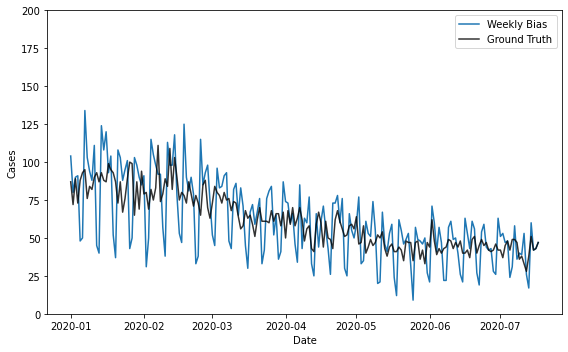

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_output_T_{time_steps}_N0_{N_0}.png")

## Fixed Bias Formulation

The simplest form of this formulation is when $C_{t} = \alpha_{w[t]} I_{t}$ - i.e. the ground truth cases are scaled by some weekday-dependant scalar constant to give the observed cases. To generate sufficient noise in the periodicity of the observed (recorded) data however, we use $C_{t} \sim Po(\alpha_{w[t]} I_{t})$, while the true cases are still given by the renewal equation $I_{t} \sim Po(R_{t} \Lambda_{t})$.


The parameters are then updated in two steps. First $I_{t}$ is updated via Metropolis-Hastings according to the following conditional probability:

$$
P(I_{t} | C_{t}, \alpha_{i}, R_{t}) = \prod Po(I_{t} | R_{t} \Lambda_{t}) \times Po(C_{t} | \alpha_{i}I_{t})
$$

Secondly, $\alpha_{i}$ are updated using Gibbs sampling from the following conditional probability:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{1, 8, 15, ...} Po(C_{t} | \alpha_{i} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

summing over all days of that given weekday (monday indicies illustrated). This may be simplified to a single Gamma distribution using a known conditional prior relation (noting that the rates of the two processes differ by a scalar $I_{t}$ and so this is not quite equal to the standard relation). The prior of $\alpha_{i}$ is given by a Gamma distribution $Gamma(a, b)$.


### Conjugate Priors for $\alpha_{i}$

As above, the conditional posterior for $\alpha_{i}$ is given by:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

where we only consider times correposnding to a single weekday (i.e. $t = {1, 8, 15...}$ for $i = 1$).

The product may be written as:

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) = \prod_{t} (\alpha_{i[t]}I_{t})^{C_{t}} \times \frac{e^{-\alpha_{i[t]} I_{t}}}{C_{t}!}
$$

which we may simplify to (also removing the constant factorial $C_{t}!$):

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \prod_{t} I_{t}^{C_{t}}
$$

Combining this with the explicit form of the gamma prior, we may therefore write that:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \alpha_{i[t]} \! ^{a-1} \times e^{-b\alpha_{i[t]}} \times \prod_{t} I_{t}^{C_{t}} 
$$

Collecting like terms, and removing the multiplicative constant $\prod_{t} I_{t}^{C_{t}}$, we arrive at the final result:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{(a + \sum_{t=i}^{n}C_{t}) - 1} \times e^{ - \alpha_{i[t]} \left(b + \sum_{t=i}^{n}I_{t}\right)}
$$

which is in the form of a Gamma distribution:

$$
P(\alpha_{i} | I_{t} , C_{t}) \sim Gamma \left(a + \sum_{t=i}^{n}C_{t}, b + \sum_{t=i}^{n}I_{t} \right)
$$


In [6]:
from sampling_methods import GibbsParameter, MetropolisParameter, MixedSampler

from synthetic_data import RenewalModel


# need to redo the ground truth sampling - can formualate independant sampling with a new parameter type (under gibbs parameter)

# form conjugate priors for the conditional probability above.


In [8]:
# is the product in the expression above over all time points?

def truth_likelihood(params):
    truth_keys = [k for k in sorted(params.keys()) if k.startswith('data_')]
    product = 1
    for i in range(len(truth_keys)):
        product *= ss.poisson.pmf(k=params['data_' + str(i)],
                                  mu=(params['bias_' + str(i % 7)] 
                                      * params['truth_' + str(i)]))
        
        # Assumes week starts on a monday, otherwise can convert later
    return product

def _calculate_gamma(params, max_t):
        omega = RenewalModel(R0=params['R_t']).serial_interval
        cases = [params[k].value for k in params.keys if k.startswith('data_')]
        n_terms_gamma = min(max_t + 1, len(omega))  # Number of terms in sum for gamma
        return sum([omega[i] * cases[-i] for i in range(1, n_terms_gamma)])


def bias_conditional_posterior_params(params, index):
    truth_keys = [k for k in sorted(params.keys()) if k.startswith('data_')]
    data_values = []; truth_values = []

    for i in range(len(truth_keys)):
        # Assumes t from 'data_t' takes integer values
        if i % 7 == index:
            data_values.append(params['data_' + str(i)])
            truth_values.append(params['truth_' + str(i)])

    params =  {'alpha': params['bias_prior_alpha'] + sum(data_values),
               'beta': params['bias_prior_beta'] + sum(truth_values)}
    return params





In [ ]:
def bias_parameter(value, index):
    """Creates Gibbs parameter object, with a gamma posterior derived
    using conjugate priors above."""
    return GibbsParameter(
        value=value, conditional_posterior=ss.gamma.ppf,
        posterior_params=bias_conditional_posterior_params(params, index))

def truth_parameter(value):
    return MetropolisParameter(value=value, likelihood=truth_likelihood)

In [ ]:
I_data = list(bias_df['Confirmed'])
params = {'bias_prior_alpha': 1, 'bias_prior_beta': 1}  # Gamma dist

params['R_t'] = 0.99  # Start with known R_t

for i, val in enumerate(I_data):  # Obsevred cases - not a Parameter
    params[("data_" + str(i)) : val]

data_initial_guess = sum(I_data)/len(I_data)  # Constant initial value
for i in range(I_data):  # Ground truth data
    params[("truth_" + str(i)) : truth_parameter(data_initial_guess)]

for i in range(7):  # Weekday bias parameters
    params[("bias_" + str(i)) : bias_parameter(1, index=i)]

sampler = MixedSampler(params=params)
output = sampler.sampling_routine(step_num=100)
output.hist([("bias_" + str(i)) for i in range(7)], bins=20);